In this notebook the mass determination of two neutron star is done. It is based on the PyCBC example found at https://github.com/gwastro/PyCBC-Tutorials/blob/master/examples/gw170817_mass_estimate.ipynb. The main difference with what has been done for the black holes is that we cannot use the data contained in PyCBC by default. So, it has to be donwloaded differently. Moreover, the data treatment is heavier. Therefore, the analysis is done differently and only the masses are inferred by a coverage of the mass parameters. Moreover, the best fit of the parameters cannot be done anymore.

We focus on the GW710817 event, the first neutron star detection.

In [1]:
%matplotlib inline 

#For the plots
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

The event was not detected in the V1 detector because it was out of its BNS range. So, we do not use that detector.

In [4]:
# Dowload the data

!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
!wget -nc https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf

File ‘H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.

File ‘L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf’ already there; not retrieving.



In [5]:
#get the data (again in order to not interference with above)
import matplotlib.pyplot as plt
from pycbc.filter import highpass
from pycbc.catalog import Merger
from pycbc.frame import read_frame

m = Merger('GW170817')
strain, stilde = {}, {}

detectors = ['L1', 'H1']

for det in detectors:
    #dwload 256s of data, containing the event
    ts = read_frame("{}-{}_LOSC_CLN_4_V1-1187007040-2048.gwf".format(det[0], det),
                    '{}:LOSC-STRAIN'.format(det),
                   start_time=m.time - 224,
                   end_time=m.time + 32,
                   check_integrity=False)
    
    #highpass and crop time domain data
    strain[det] = highpass(ts, 15)
    strain[det] = strain[det].crop(4,4)
    
    #frequency domain version of the data
    stilde[det] = strain[det].to_frequencyseries()
    
    

Text(0,0.5,'Strain')

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


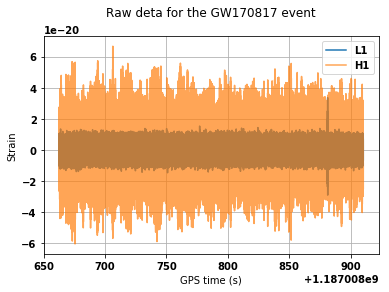

In [6]:
#plotting the data

alphas = {}
alphas['L1'] = 1
alphas['H1'] = 0.7

for det in detectors:
    plt.plot(strain[det].sample_times, strain[det], alpha=alphas[det], label = det)
    
plt.legend()
plt.grid()
plt.title('Raw deta for the GW170817 event', pad = 20)
plt.xlabel('GPS time (s)')
plt.ylabel('Strain')

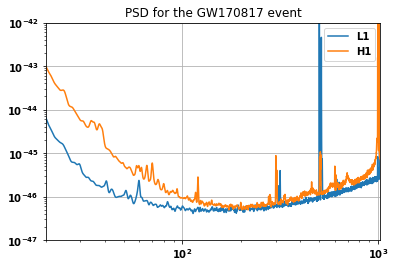

In [7]:
#making the psd of the data

from pycbc.psd import interpolate, inverse_spectrum_truncation

psds = {}

for det in detectors:
    psds[det] = strain[det].psd(2)
    psds[det] = interpolate(psds[det], stilde[det].delta_f)
    psds[det] = inverse_spectrum_truncation(psds[det], 
                                            2*strain[det].sample_rate,
                                           low_frequency_cutoff = 15.0,
                                           trunc_method = 'hann')
    
    plt.loglog(psds[det].sample_frequencies, psds[det], label = det)
    plt.xlim(20,1024)
    plt.ylim(1e-47, 1e-42)
plt.legend(loc='best')
plt.title('PSD for the GW170817 event')
plt.grid()

In [8]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter
import numpy as np

mass1 = np.arange(1.36, 1.58, 0.01)
mass2 = np.arange(1.18, 1.36, 0.01)

hmax, smax, tmax, m1max, m2max, nsnr =  None, {}, {}, 0,0, 0
snrs = []




for m1 in mass1:
    for m2 in mass2:
        #waveform with the masses 
        hp, hc = get_fd_waveform(approximant = "TaylorF2", mass1 = m1,
                                mass2 = m2, f_lower = 20., 
                                delta_f = stilde[det].delta_f)
        hp.resize(len(stilde[det]))
        
        #do the matched filtering
        max_snr, max_time = {}, {}
        
        for det in detectors:
            snr = matched_filter(hp, stilde[det], psd = psds[det], 
                                low_frequency_cutoff = 20.0)
            
            snr = snr.time_slice(m.time - 1, m.time + 1)
            _, idx = snr.abs_max_loc()
            max_snr[det] = snr[idx]
            max_time[det] = float(idx) / snr.sample_rate + snr.start_time
        
        #computation of the network snr
        net_snr = (abs(np.array(max_snr.values()))**2.0).sum() ** 0.5
        snrs.append(max_snr)
        
        #loudest peak
        if net_snr > nsnr:
            tmax, hmax, m1max, m2max, smax = max_time, hp, m1, m2, max_snr
            nsnr = net_snr

print("The best fitting masses found are %.3f and %.3f solar masses for M1 and M2, resp" %(m1max, m2max))

The best fitting masses found are 1.480 and 1.280 solar masses for M1 and M2, resp


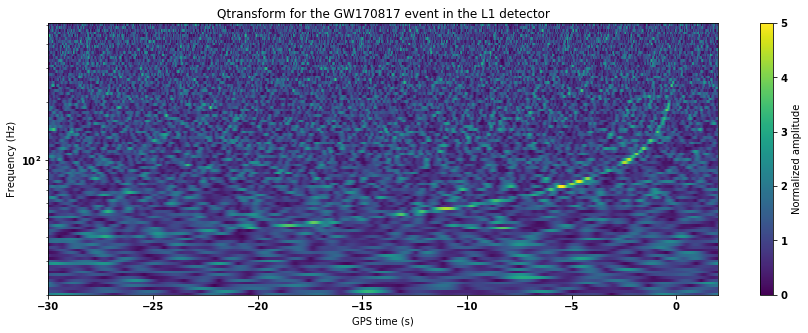

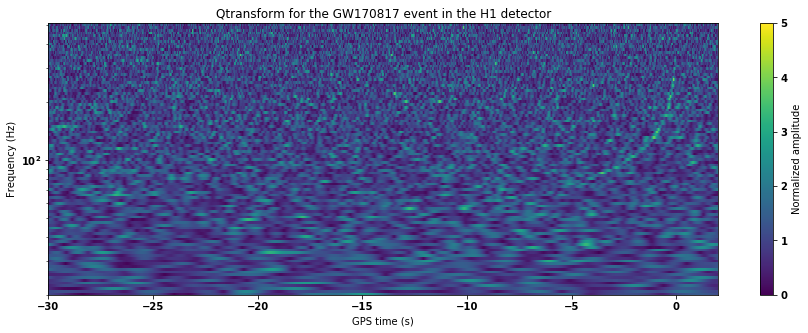

In [9]:
#representation  of the data
for det in detectors:
    #white data
    
    white = (stilde[det]/psds[det]**0.5).to_timeseries()
    zoom = white.time_slice(m.time-30, m.time+2)
    
    #qtransform
    t, f, p = zoom.qtransform(.01, logfsteps = 100, frange = (20,512),
                             qrange = (110,110))
    plt.figure(figsize = [15,5])
    im = plt.pcolormesh(t-m.time, f, p**0.5, vmin = 0, vmax = 5)
    plt.ylim(20,512)
    plt.title("Qtransform for the GW170817 event in the %s detector" %det)
    plt.xlabel("GPS time (s)")
    plt.ylabel('Frequency (Hz)')
    plt.yscale('log')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Normalized amplitude')

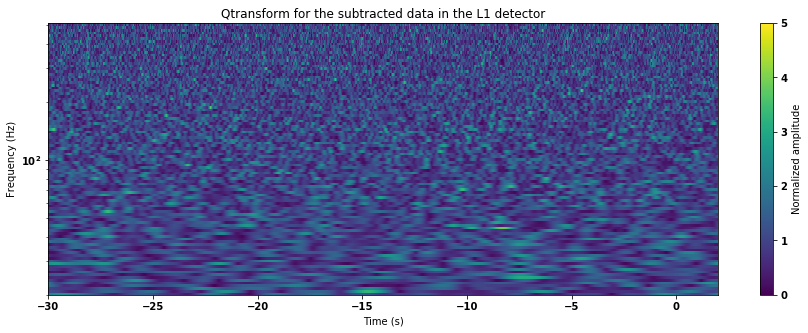

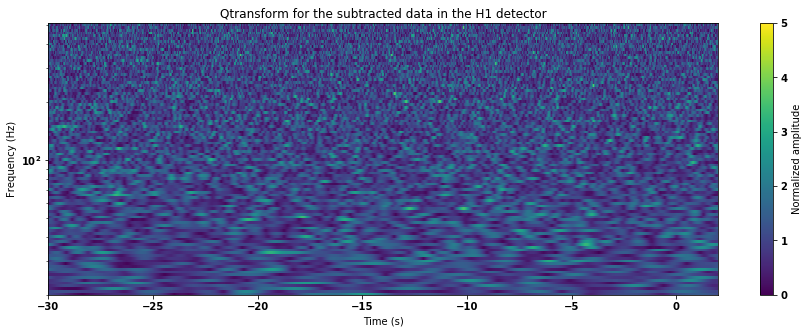

In [10]:
#we can subtract the best fit template (hmax) from the data to see what
#if it is well subtracted.
#this signal can then be used to see what is the SNR as function of the 
#fraction of signal taken into acount

from pycbc.filter import sigma

injs = {}
stilde2 = {}
white_data = {}

for det in detectors:
    #shift template to time of max
    dt = tmax[det] - stilde[det].start_time
    inj = hmax.cyclic_time_shift(dt)
    
    #scale template to SNR
    inj /= sigma(hmax, psd=psds[det], low_frequency_cutoff = 20.0)
    inj *= smax[det]
    
    injs[det] = inj
    
    #subtracted data
    stilde2[det] = stilde[det] - inj
    
    #whiten the subtracted data
    hoft = (stilde2[det]/psds[det]**0.5).to_timeseries()
    white_data[det] = hoft
    
    #time around the event
    zoom = hoft.time_slice(m.time - 30, m.time + 2)
    
    #qtransform
    t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
    plt.figure(figsize = [15,5])
    im = plt.pcolormesh(t-m.time, f, p**0.5, vmin = 0, vmax = 5)
    plt.ylim(20,512)
    plt.title("Qtransform for the subtracted data in the %s detector" %det)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.yscale('log')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Normalized amplitude')

With this, we were able to determine the best fit data in the scenario of two different masses, the other parameters being unknow. This lead to the best fit signal, with the highest network SNR. This is only an example of the data. The ultimate goal is to see what happens if we take fraction of the signal into account. However, it can be noted that, in order to have a better precision or to understand what happen for the other parameters, we could also loop over them. 

/home/justin/.local/lib/python2.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


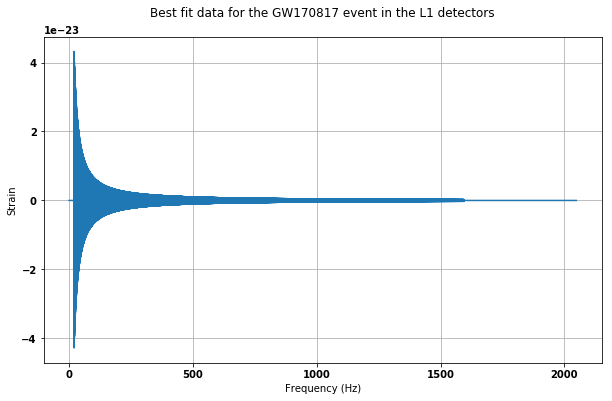

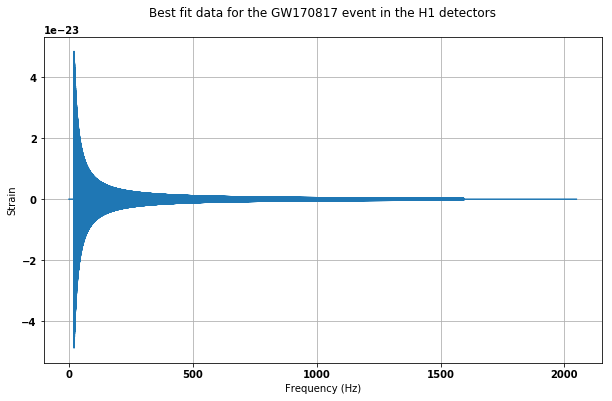

In [11]:
#we can look at what the best fit signal looks like:
for det in detectors:
    plt.figure(figsize = [10,6])
    plt.plot(injs[det].sample_frequencies, injs[det])
    plt.title('Best fit data for the GW170817 event in the %s detectors' %det, pad = 20)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel("Strain")
    plt.grid()

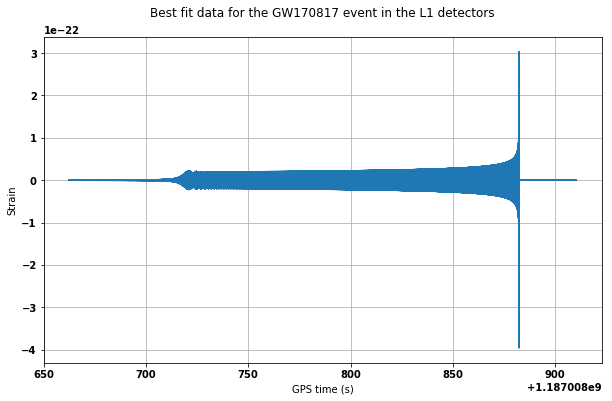

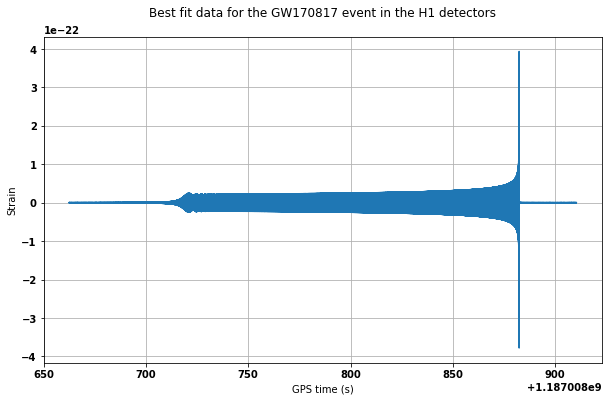

In [12]:
#conversion of the best fit templates as timeseries
from pycbc.types import TimeSeries

best_fit_t = {}

for det in detectors:
    best_fit_t[det] = injs[det].to_timeseries()
    best_fit_t[det] = TimeSeries(best_fit_t[det], 
                                 delta_t = best_fit_t[det].delta_t, 
                                 epoch = stilde2[det].start_time)

for det in detectors:
    plt.figure(figsize = [10,6])
    plt.plot(best_fit_t[det].sample_times, best_fit_t[det])
    plt.title('Best fit data for the GW170817 event in the %s detectors' %det, pad = 20)
    plt.xlabel('GPS time (s)')
    plt.ylabel("Strain")
    plt.grid()

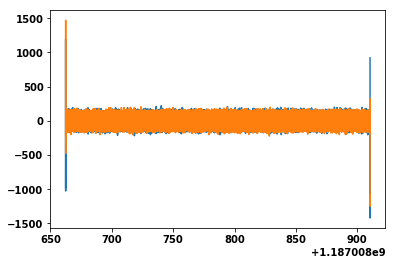

In [13]:
#quick view on what the subtracted data looks like

for det in detectors:
    plt.plot(white_data[det].sample_times, white_data[det])

The peaks at the end are not due to any signal but are artefacts due to the cutting. Tese are artifacts that can be taken away by cuting the few first and last seconds (see the black hole example)

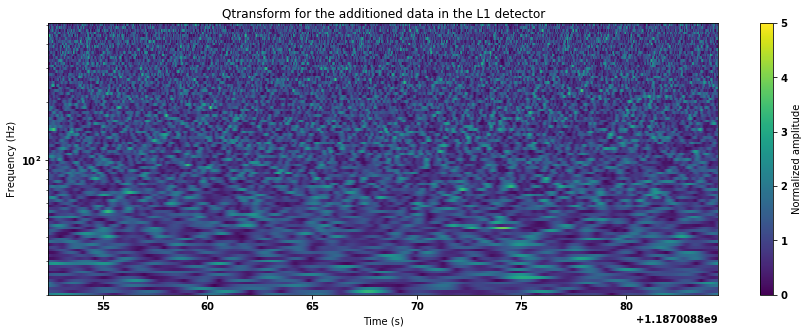

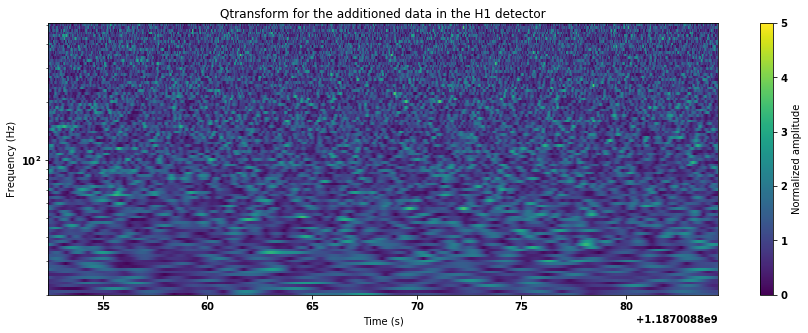

In [14]:
#test: see if the two pieces togheter enable to retrieve the full data
added = {}

for det in detectors:
    added[det] = white_data[det] + best_fit_t[det]
    zoom = added[det].time_slice(m.time - 30, m.time + 2)
    #qtransform
    t, f, p = zoom.qtransform(.01, logfsteps=100, frange = (20,512),
                             qrange = (110,110))
    plt.figure(figsize = [15,5])
    im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
    plt.ylim(20,512)
    plt.title("Qtransform for the additioned data in the %s detector" %det)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.yscale('log')
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Normalized amplitude')

The simple addition of the best fit data and the subtracted data does not enable to find the signal back. This means that, in order to see how the SNR evolves, we will need to use another method than the one used for the black holes.

The best fit masses are 1.48 and 1.28

For a black hole analysis, we would have used a best fit approach to adjust a bit better. However, this is to heavy to be feasible here (for a classical laptop)